In [1]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image, ImageChops

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

torch.set_printoptions(threshold=100, linewidth=160, edgeitems=4, precision=3)

# BIT AI - 03 Sieci neuronowe

## Zbiór danych
Używamy datasetu FashionMNIST - niżej pobieramy i ładujemy go.

Dodatkowo robimy podział zbioru **train** na **train** i **val**. Na zbiorze **val** będziemy często sprawdzać jak nam idzie, żeby nie ruszać zbioru **test** - na nim sprawdzimy tylko na koniec.

In [2]:
torch.manual_seed(0)
train_set = FashionMNIST("data", download=True, train=True, transform=ToTensor())
train_set = Subset(train_set, np.arange(1800))

train_set, val_set = random_split(train_set, [1500, 300])

test_set = FashionMNIST("data", download=True, train=False, transform=ToTensor())

classes = test_set.classes

print(f"Train size: {len(train_set)}")
print(f"Val size: {len(val_set)}")
print(f"Test size: {len(test_set)}")
print(f"Classes: {classes}")

Train size: 1500
Val size: 300
Test size: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Tak wyglądają dane - mamy dużo par (zdjęcie, klasa).
Zdjęcia mamy o rozdzielczości 28x28. 

In [3]:
for i in range(3):
    img, label = train_set[i]
    print(img, label)
    print()

tensor([[[0.000, 0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000,  ..., 0.557, 0.000, 0.004, 0.000],
         [0.000, 0.000, 0.000, 0.000,  ..., 0.855, 0.000, 0.000, 0.000],
         [0.000, 0.000, 0.000, 0.000,  ..., 0.875, 0.000, 0.000, 0.000],
         ...,
         [0.000, 0.255, 1.000, 0.933,  ..., 0.800, 0.855, 0.486, 0.000],
         [0.000, 0.000, 0.173, 0.616,  ..., 0.831, 0.875, 0.463, 0.000],
         [0.000, 0.000, 0.000, 0.000,  ..., 0.776, 0.776, 0.396, 0.000],
         [0.000, 0.000, 0.008, 0.000,  ..., 0.000, 0.000, 0.000, 0.000]]]) 9

tensor([[[0., 0., 0., 0.,  ..., 0., 0., 0., 0.],
         [0., 0., 0., 0.,  ..., 0., 0., 0., 0.],
         [0., 0., 0., 0.,  ..., 0., 0., 0., 0.],
         [0., 0., 0., 0.,  ..., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.,  ..., 0., 0., 0., 0.],
         [0., 0., 0., 0.,  ..., 0., 0., 0., 0.],
         [0., 0., 0., 0.,  ..., 0., 0., 0., 0.],
         [0., 0., 0., 0.,  ..., 0., 0., 

In [4]:
test_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Parę przykładów jak wyglądają zdjęcia i do jakie mają oznaczenia klas. Rozdzielczość troche mała, ale tak właściwie to widać co to.

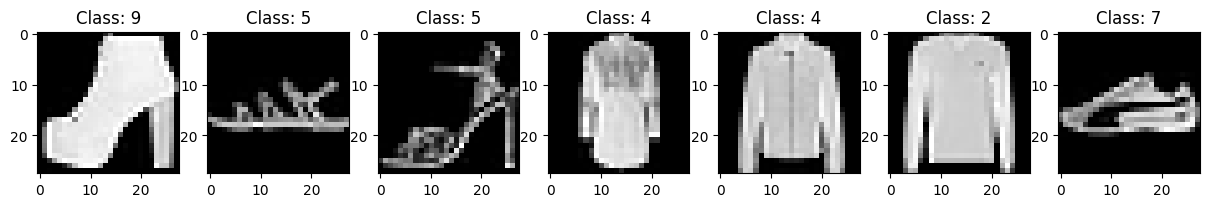

In [5]:
fig, axs = plt.subplots(ncols=7, figsize=(15, 5))
for i, ax in enumerate(axs):
    img, label = train_set[i]
    ax.imshow(img[0], cmap="gray")
    ax.set_title(f"Class: {label}")

Warto sprawdzić czy klasy są zbalansowane.

<Axes: >

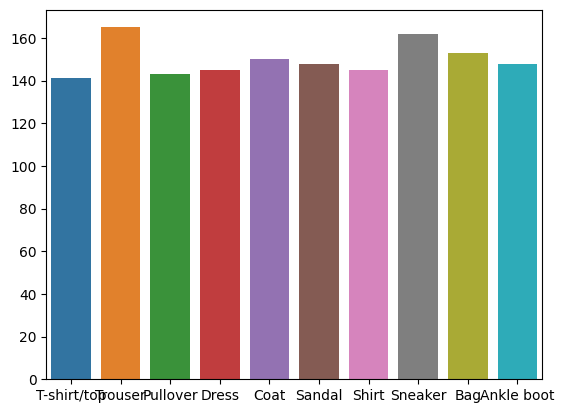

In [6]:
_, counts = np.unique([y for X, y in train_set], return_counts=True)
sns.barplot(y=counts, x=classes)

### Model sieci neuronowej
Konstruujemy naszą sieć neuronową. W konstruktorze (*\__init__*) inicjalizujemy nasze warstwy. W funkcji *forward* wywołujemy po kolei warstwy/transformacje a potem zwracamy wynik.

In [7]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, img_shape, n_classes):
        super().__init__()

        total_pixels = img_shape[0] * img_shape[1]
        self.layer1 = nn.Linear(in_features=total_pixels, out_features=128)
        self.layer2 = nn.Linear(in_features=128, out_features=128)
        self.layer3 = nn.Linear(in_features=128, out_features=n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

In [8]:
model = MyNeuralNetwork(img_shape=[28, 28], n_classes=10)
model

MyNeuralNetwork(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

Możemy podejrzeć parametry modelu - widać że zainicjowane są do małych losowych wartości. 

In [9]:
for params in model.parameters():
    print(params, params.shape, sep="\n", end="\n\n")

Parameter containing:
tensor([[-0.001,  0.005,  0.000, -0.026,  ..., -0.013, -0.035,  0.029, -0.008],
        [ 0.007, -0.010,  0.023,  0.035,  ..., -0.022, -0.015,  0.005, -0.008],
        [-0.020,  0.000, -0.011,  0.022,  ...,  0.018,  0.033, -0.033, -0.016],
        [ 0.030, -0.002,  0.007,  0.005,  ..., -0.034, -0.010, -0.004,  0.019],
        ...,
        [-0.015, -0.010,  0.017,  0.035,  ..., -0.022,  0.018, -0.006, -0.030],
        [ 0.011,  0.013,  0.032,  0.018,  ...,  0.017, -0.023, -0.034, -0.019],
        [-0.027,  0.021,  0.016, -0.000,  ..., -0.015,  0.024, -0.009, -0.029],
        [ 0.000, -0.025, -0.034,  0.002,  ...,  0.035, -0.006,  0.032, -0.001]], requires_grad=True)
torch.Size([128, 784])

Parameter containing:
tensor([ 0.003, -0.033, -0.032, -0.015,  ..., -0.027,  0.010,  0.029, -0.008], requires_grad=True)
torch.Size([128])

Parameter containing:
tensor([[-0.013,  0.010,  0.053, -0.030,  ..., -0.078, -0.031,  0.036, -0.007],
        [-0.063, -0.047, -0.054, -0.04

Model nie jest wytrenowany - póki co ma losowe parametry. Ale moze przyjąć zdjęcie i powinien zwrócić jakąś wartość - raczej w miare losową. Można zauważyć też, że pytorch cachuje nam dane potrzebne do policzenia potem gradientów.



Model skonfigurowany jest tak, że przyjmuje na wejściu tensor o wymiarach [BS, 28, 28], gdzie BS to batch_size - można mu podać wiele zdjęć na raz. Na wyjściu powinien zwracać tensor o wymiarach [BS, 10], czyli tak jakby listę wektorów z wynikami dla każdej z 10 klas.

In [10]:
img = train_set[0][0]
model(img)

tensor([[ 0.163, -0.077, -0.036, -0.095,  0.132,  0.091, -0.187, -0.095, -0.049, -0.108]], grad_fn=<AddmmBackward0>)

Funkcja softmax przyda się, żeby wyjścia modelu przekształcić w prawdopodobieństwa - tak by wszystkie były od 0 do 1 i sumowały się do 1.

In [11]:
F.softmax(model(img), dim=1)

tensor([[0.120, 0.094, 0.098, 0.093, 0.116, 0.112, 0.085, 0.093, 0.097, 0.092]], grad_fn=<SoftmaxBackward0>)

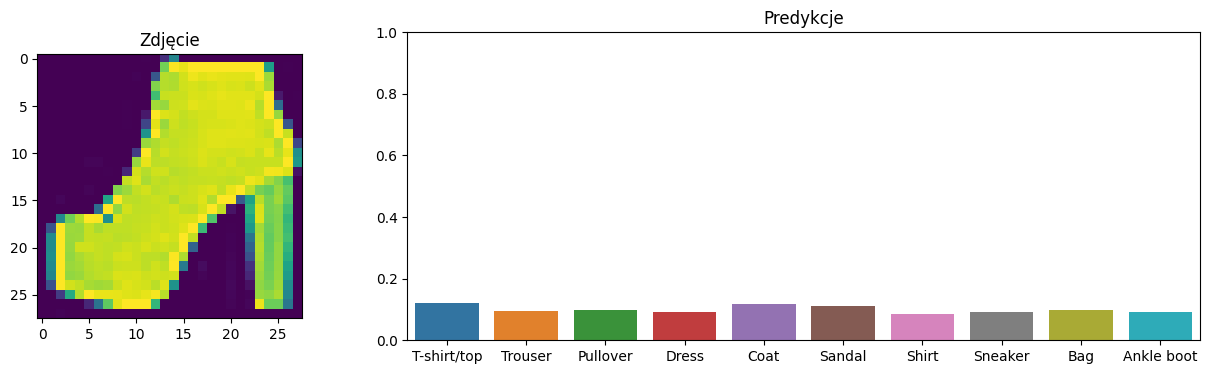

In [12]:
def plot_pred(img, model):
    preds = model(img)
    preds = F.softmax(preds, dim=1)
    preds = preds[0].tolist()

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 3]})
    ax1.imshow(img.reshape(28, 28))
    ax1.set_title("Zdjęcie")
    sns.barplot(y=preds, x=classes, ax=ax2)
    ax2.set_ylim(0, 1)
    ax2.set_title("Predykcje")
    plt.show()


plot_pred(img, model)

DataLoader to taka klasa, która pomoże nam w iterowaniu przez dataset. Argument *batch_size* mówi po ile zdjęć bierzemy za jednym razem. Niżej widać jak możemy iterować przez taki loader i co dostajemy. Długość (pythonowe len) jest mniejsza niż długość całego datasetu bo tym razem liczymy batche a nie pojedyncze przykłady. 

In [13]:
train_loader = DataLoader(train_set, batch_size=8)
test_loader = DataLoader(test_set, batch_size=8)

print(len(train_loader))
print(len(test_loader))

188
1250


In [14]:
for X, y in train_loader:
    print(X, X.shape)
    print(y, y.shape)
    break

tensor([[[[0.000, 0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000, 0.000],
          [0.000, 0.000, 0.000, 0.000,  ..., 0.557, 0.000, 0.004, 0.000],
          [0.000, 0.000, 0.000, 0.000,  ..., 0.855, 0.000, 0.000, 0.000],
          [0.000, 0.000, 0.000, 0.000,  ..., 0.875, 0.000, 0.000, 0.000],
          ...,
          [0.000, 0.255, 1.000, 0.933,  ..., 0.800, 0.855, 0.486, 0.000],
          [0.000, 0.000, 0.173, 0.616,  ..., 0.831, 0.875, 0.463, 0.000],
          [0.000, 0.000, 0.000, 0.000,  ..., 0.776, 0.776, 0.396, 0.000],
          [0.000, 0.000, 0.008, 0.000,  ..., 0.000, 0.000, 0.000, 0.000]]],


        [[[0.000, 0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000, 0.000],
          [0.000, 0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000, 0.000],
          [0.000, 0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000, 0.000],
          [0.000, 0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000, 0.000],
          ...,
          [0.000, 0.000, 0.000, 0.000,  ..., 0.000, 0.000, 0.000, 0.000],
    

## Trening
Niżej definiujemy różne rzeczy - model, optimizer, hiperparametry i takie tam. 
Przygotowujemy trzy loadery:
- treningowy - na nim będziemy uczyć sieć
- walidacyjny - na nim będziemy sprawdzać jak nam idzie
- testowy - na nim zweryfikujemy wyniki na sam koniec

In [15]:
model = MyNeuralNetwork(img_shape=[28, 28], n_classes=10)

loss_fun = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

num_epochs = 30

Trenujemy - w każdej epoce przechodzimy przez cały treningowy loader.

W pojedynczej epoce dla każdego batcha:
- wywołujemy model
- wyliczamy loss (błąd na danej grupie przykładów)
- gradienty (ważne!)
  - optimizer.zero_grad() - zeruje nam wcześniej policzone gradienty
  - loss.backward() - oblicza gradienty algorytmem propagacji wsteczej
  - optimizer.step() - updatuje parametry robiąc kroczek
- zapisujemy sobie wartość funkcji loss i na ilu przykładach model przewidział poprawnie, żeby podsumować sobie potem po całej epoce

Uwaga - jeśli odpalicie tą komórkę wielokrotnie bez resetowania parametrów, to model będzie się dotrenowywał.

In [16]:
for epoch in range(1, num_epochs + 1):
    model.train()

    train_loss = 0
    train_correct = 0
    for X, y in train_loader:
        output = model(X)
        loss = loss_fun(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += output.argmax(dim=1).eq(y).sum().item()

    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)

    ############
    # ZADANIE 2

    model.eval()
    val_loss = 0
    val_correct = 0
    for X, y in val_loader:
        output = model(X)
        loss = loss_fun(output, y)

        val_loss += loss.item()
        val_correct += output.argmax(dim=1).eq(y).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)
    ############

    print(f"Epoch {epoch}")
    print(f"  Training loss: {train_loss:.4f}, training acc: {train_acc:.4f}")
    print(f"  Validation loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

Epoch 1
  Training loss: 2.2452, training acc: 0.4000
  Validation loss: 2.1840, val acc: 0.5067
Epoch 2
  Training loss: 2.1132, training acc: 0.5453
  Validation loss: 2.0307, val acc: 0.5567
Epoch 3
  Training loss: 1.9322, training acc: 0.5753
  Validation loss: 1.8245, val acc: 0.5600
Epoch 4
  Training loss: 1.7128, training acc: 0.5867
  Validation loss: 1.6034, val acc: 0.5700
Epoch 5
  Training loss: 1.4980, training acc: 0.5887
  Validation loss: 1.4064, val acc: 0.5800
Epoch 6
  Training loss: 1.3166, training acc: 0.6053
  Validation loss: 1.2485, val acc: 0.6133
Epoch 7
  Training loss: 1.1765, training acc: 0.6340
  Validation loss: 1.1297, val acc: 0.6567
Epoch 8
  Training loss: 1.0723, training acc: 0.6620
  Validation loss: 1.0425, val acc: 0.6533
Epoch 9
  Training loss: 0.9944, training acc: 0.6773
  Validation loss: 0.9768, val acc: 0.6667
Epoch 10
  Training loss: 0.9343, training acc: 0.6927
  Validation loss: 0.9258, val acc: 0.6767
Epoch 11
  Training loss: 0.8

Jeśli trening działa, to loss powinien spadać z każdą epoką, a accuracy powinno rosnąć. Trzeba pamiętać, że to wyniki na treningowym datasecie. Niżej sprawdzimy na testowym datasecie. 

## Walidacja 

Zwykle wyniki na treningowym datasecie są trochę lepsze niż na nowych danych. Nie powinniśmy jednak trenować go zbyt mocno/długo - w końcu model może zapamiętać cały treningowy dataset, a w praktyce (na walidacyjnym/testowym) działać słabiej. 

Tutaj trzeba mieć na uwadze, że mamy bardzo duży dataset, więc tych problemów będzie mniej.

In [17]:
model.eval()
loss = 0
correct = 0
for X, y in test_loader:
    output = model(X)
    loss += loss_fun(output, y).item()
    correct += output.argmax(dim=1).eq(y).sum().item()

loss = loss / len(test_loader)
acc = correct / len(test_loader.dataset)

print(f"Loss: {loss:.4f}, acc: {acc:.4f}")

Loss: 0.6488, acc: 0.7646


## Zadanka

### Zadanie 1
Sprawdź i wyświetl funkcją `plot_pred(img, model)` jakiś przykład z datasetu testowego, na którym sieć zrobiła pomyłkę.


### Zadanie 2
Dopisz do pętli treningowej sprawdzanie sieci na datasecie walidacyjnym, tak by co epokę mieć wypisane wartości - *validation loss* i *validation acc*. 

(dopisz kod wyżej, w wyznaczonym miejscu w pętli treningowej)


### Zadanie 3
Znajdź jakieś zdjęcie z Zalando albo jakiegos innego sklepu z ubraniami i sprawdź czy sieć sobie z nim poradzi. 


Niżej funkcja, która pomoże zrobić preprocessing - trzeba tylko podać url.


In [18]:
def img_preprocessing(url):
    img = Image.open(urlopen(url)).convert("L")
    img = img.resize((28, 28))
    img = ImageChops.invert(img)
    return ToTensor()(img).unsqueeze(dim=0)